# Steam (Environment - Agent)

In [1]:
# Basic import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm
import pdb
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
from tensorflow.keras.models import Model
tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)
print("OOOOOOOK")

2.0.0


## Environment

In [2]:
class Environment:
    """ 
    Contextual Multi-Armed Bandit environment
    """
    def __init__(self, nb_films, nb_users, 
                 context_size = 2,
                 displayed_users_embedding_size = 2, #used for the features vector
                 displayed_games_embedding_size = 2, #used for the features vector
                 noise_size = 3,
                 seed=None):     
        
        self._rng = np.random.RandomState(seed)
        #-------------------------------------------------------#
        
        self._nb_games = nb_games
        self._nb_users = nb_users
        self._p = context_size # size of user, size of game
        self._displayed_users_embedding_size = displayed_users_embedding_size
        self._displayed_games_embedding_size = displayed_games_embedding_size
        self._noise_size = noise_size
   
        #-------------------------------------------------------#
    
        self.user_mean = np.ones(self._p)
        self.user_var = np.ones(self._p)
        self.game_mean = np.ones(self._p)
        self.game_var = np.ones(self._p)
        
        #-------------------------------------------------------#
        self.finish = False # flag to know when reset the environment (all games played)
    
    def step(self):
        
        if self._available_games.sum() == 0:#if all players played all games
            self.finish = True
            print("All games played reset the environment")
            return 0,0, self.finish
            
        """ Choose a game """
        user = self.get_next_user()#always a user that have at least one gama still to play
        
        
        available_games = np.where(self._available_games[user] == 1)[0]
        optimal_reward = np.max(self._reward_matrix[user,available_games])
        return user, available_games, optimal_reward, self.finish
    
    def get_next_user(self):
        
        user = self._rng.randint(0, self._nb_users)
        
        if np.sum(self._available_games[user,:]) > 0:#still some games to play
            return user
        else:#all games played for the current user--> change and find a random one between the one who still have some games
            row,cols = np.where(self._available_games == 1)
            #pdb.set_trace()
            ret = self._rng.choice(row)
            return ret
    
    def update(self, user, game):
        reward = self._reward_matrix[user, game]
        self._available_games[user, game] = 0
        return reward
    
    def reset(self):
        self.finish = False
        self._users = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self._nb_users, self._p))
        self._games = self._rng.normal(loc=self.game_mean,
                                                scale=self.game_var,
                                                size=(self._nb_games, self._p))
        
        z_mean = self.user_mean.dot(self.game_mean)
        z_var = self.user_var.dot(self.game_var) + self.user_var.dot(np.square(self.game_mean)) + \
                self.game_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # buckets
        self._available_games = np.ones((nb_users, nb_games))        
        
        self._reward_matrix = np.zeros((nb_users, nb_games))
        
        for i in range(self._reward_matrix.shape[0]):
            for j in range(self._reward_matrix.shape[1]):
                real_score = self._users[i].dot(self._games[j])
                self._reward_matrix[i, j] = np.searchsorted(self.z_cut_points, real_score) + 1

        users = deepcopy(self._users)
        return users

    def get_feature_vector(self, user, game):
        user_embedding = self._users[user]
        game_embedding = self._games[game]
        
        if self._displayed_users_embedding_size + self._displayed_games_embedding_size > 0:
            variables = np.array([user_embedding[:self._displayed_users_embedding_size],
                                  game_embedding[:self._displayed_games_embedding_size]])

            if self._noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self._noise_size),
                                         scale=np.ones(self._noise_size),
                                         size=self._noise_size)
                
                variables = np.append(variables, noise)
                
        return variables
        
        
    def reset_seed(self, seed=None):
        self._rng = np.random.RandomState(seed)
        return

## Agent

In [3]:
class RandomAgent:
    """ 
    Random agent
    """
    def __init__(self, seed = None):
        self._rng = np.random.RandomState(seed)
    
    def act(self, available_games):
        action = self._rng.choice(available_games)
        return action

## Experiment

In [4]:
# Basic parameter
nb_users = 30 #number of users in the context
nb_games = 10 #number of games in the context
context_size = 2 #number of different film categories = 2

In [5]:
# Creating the environment
env = Environment(nb_games,nb_users,context_size,seed=2020)
env.reset() #reset and initilize the environment

array([[-0.76884571,  1.07555227],
       [-0.1306297 ,  0.34856983],
       [ 0.10688437, -0.27410098],
       [ 0.93884557,  1.06451384],
       [ 1.41011295,  0.42711751],
       [ 0.19866638,  2.31203519],
       [ 2.27469887, -0.2143576 ],
       [ 1.31371941, -0.44482142],
       [ 0.6310387 ,  0.23077342],
       [ 1.3926161 ,  1.05729383],
       [ 3.08997884,  1.04197131],
       [ 0.95165928,  0.48684608],
       [ 0.91541072, -0.21545008],
       [-0.41293073, -0.48691055],
       [ 1.38222486,  1.937673  ],
       [ 2.77267804,  1.87882801],
       [ 1.33171912,  0.69396433],
       [ 2.24026615,  0.78437316],
       [ 1.15592948,  1.09805553],
       [ 1.83209585,  3.04520542],
       [ 0.68318608, -0.31283291],
       [-0.75445746,  1.10209408],
       [-0.36150208,  1.48178488],
       [ 0.79167126,  0.90813649],
       [ 1.70268816,  1.10365506],
       [ 1.62123638,  1.95411497],
       [ 3.03781352,  0.51554878],
       [ 1.2071549 ,  2.64424216],
       [ 0.5117926 ,

In [6]:
# Creating the agent
agent = RandomAgent(2020)

We run the experiment and generate some historical data.

In [7]:
# Running several trials
nb_iteration = 100 #how many trials
rating_matrix = np.zeros((env._nb_users, env._nb_games))
users = list()
games = list()
ratings = list()
for i in range(nb_iteration):
    user, available_games, _, finish = env.step()
    if finish:
        print("Maybe too many trial try to reduce and reset the environment")
        break
    choosen_game = agent.act(available_games)
    reward = env.update(user, choosen_game)
    users.append(user)
    games.append(choosen_game)
    ratings.append(reward)
    rating_matrix[user, choosen_game] = reward
    '''
    print("user = {}, recommended_games = {}, choosen_game = {}".format(user,recommended_games,choosen_game))
    print("reward = {}\n".format(reward))
    '''
    
print("rating matrix: \n", str(rating_matrix))

rating matrix: 
 [[0. 0. 0. 3. 0. 0. 0. 2. 2. 0.]
 [0. 0. 1. 2. 1. 0. 0. 0. 0. 1.]
 [0. 0. 2. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 3. 4. 2. 0. 0. 0. 3. 3. 2.]
 [0. 3. 0. 0. 0. 0. 3. 0. 5. 1.]
 [2. 0. 5. 1. 5. 3. 0. 0. 3. 3.]
 [0. 2. 4. 0. 0. 2. 0. 0. 0. 0.]
 [2. 2. 2. 0. 0. 2. 0. 2. 2. 2.]
 [2. 0. 0. 2. 5. 4. 0. 0. 4. 2.]
 [0. 4. 0. 0. 5. 0. 0. 4. 0. 0.]
 [0. 2. 3. 2. 0. 0. 0. 0. 0. 0.]
 [2. 0. 3. 0. 4. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 4. 5. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 0. 0. 0. 4. 0. 0.]
 [2. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [3. 5. 0. 4. 0. 0. 0. 5. 5. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [2. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 1. 3. 2. 0. 3. 0.]
 [0. 0. 3. 0. 0. 0. 2. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 3. 5. 0. 2. 4. 0. 0.]
 [0. 0. 0. 0. 0. 4. 1. 0. 4. 0.]
 [3. 0. 0. 4. 4. 0. 2. 0. 5. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 3. 4. 2. 0. 0. 0. 4. 

## Regression model

In [8]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        y = self.dot([user_vecs, game_vecs])
        return y

## Deep regression model

In [9]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dense1 = Dense(16, activation="relu")
        self.dense2 = Dense(8, activation="relu")
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        feature_inputs = inputs[2]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        # input_vecs = self.concat([user_vecs, game_vecs, self.flatten(feature_inputs)])
        input_vecs = self.concat([user_vecs, game_vecs])
        
        y = self.dense1(input_vecs)
        y = self.dense2(y)
        
        return y

## Embedding agent

In [10]:
class EmbeddingAgent:
    def __init__(self, X, Y, deepRegression=False):
        if deepRegression:
            self._model = DeepRegressionModel(64, nb_users, nb_games) ## passare nb
        else:
            self._model = RegressionModel(64, nb_users, nb_games)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,
                  batch_size=64, epochs=100, validation_split=0.1,
                  shuffle=True)
        self._user_embeddings = self._model.get_weights()[0]
        self._game_embeddings = self._model.get_weights()[1]
    
    def act(self, user, available_games):
        user_embedding = self._user_embeddings[user]
        dot_products = self._game_embeddings @ user_embedding
        user_embedding_norm = np.linalg.norm(user_embedding)
        all_item_norms = np.linalg.norm(self._game_embeddings, axis=1)
        norm_products = user_embedding_norm * all_item_norms
        sims = dot_products / (norm_products)
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

In [33]:
deepRegression = True

users = np.array(users)
games = np.array(games)
ratings = np.array(ratings)

if deepRegression:
    features = []
    for i in range(len(users)):
        features.append(env.get_feature_vector(users[i], games[i]))
    features = np.float64(features)
    agent = EmbeddingAgent([users, games, features], ratings, deepRegression=deepRegression)
else:
    agent = EmbeddingAgent([users, games], ratings, deepRegression=deepRegression)

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 1ms/sample - loss: 2.7487 - val_loss: 2.9799
Epoch 2/100
90/90 [==============================] - 0s 470us/sample - loss: 2.7392 - val_loss: 2.9713
Epoch 3/100
90/90 [==============================] - 0s 516us/sample - loss: 2.7289 - val_loss: 2.9617
Epoch 4/100
90/90 [==============================] - 0s 491us/sample - loss: 2.7177 - val_loss: 2.9509
Epoch 5/100
90/90 [==============================] - 0s 575us/sample - loss: 2.7059 - val_loss: 2.9390
Epoch 6/100
90/90 [==============================] - 0s 647us/sample - loss: 2.6928 - val_loss: 2.9259
Epoch 7/100
90/90 [==============================] - 0s 516us/sample - loss: 2.6789 - val_loss: 2.9120
Epoch 8/100
90/90 [==============================] - 0s 582us/sample - loss: 2.6638 - val_loss: 2.8970
Epoch 9/100
90/90 [==============================] - 0s 527us/sample - loss: 2.6474 - val_loss: 2.8808
Epoch 10/100
90/90 [===========

In [34]:
prev_env = deepcopy(env)

In [37]:
nb_iteration = 50
nb_exp = 100
#---------------#
regret = np.zeros(nb_exp)
cum_regret = np.zeros((nb_exp, nb_iteration))

for t in range(nb_exp):
    env = deepcopy(prev_env)
    env.reset_seed()
    regrets = np.zeros(nb_iteration)
    for i in range(nb_iteration):
        user, available_games, optimal_reward, finish = env.step()
        if finish:
            print("Maybe too many trial try to reduce and reset the environment")
            break
        choosen_game = agent.act(user, available_games)
        reward = env.update(user, choosen_game)
        regrets[i] = optimal_reward - reward
        # print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
        # print("reward = {}\n".format(reward))
    cum_regret[t] = np.cumsum(regrets)
    regret[t] = np.sum(regrets)

## Measuring performances

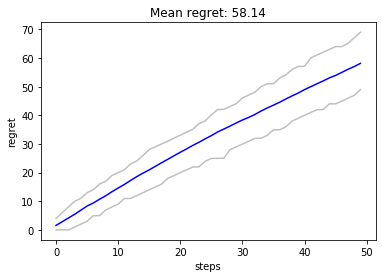

In [38]:
plt.plot(cum_regret.mean(axis=0), color='blue')
plt.plot(np.quantile(cum_regret, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(cum_regret, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()